# Imports

In [1]:
import os
import cv2
import time
import random
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report

2024-03-22 16:29:44.705772: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-22 16:29:44.705901: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-22 16:29:44.878842: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Reading Data

In [2]:
def load_df(path):
    x, y = [], []
    
    for folder in tqdm(os.listdir(path)):
        for file in os.listdir(f'{path}/{folder}'):
            x.append(f'{path}/{folder}/{file}')
            y.append(folder)
        
    dataset = {
        'image': x,
        'label': y
    }
    
    return pd.DataFrame(dataset)

In [3]:
root_path = '/kaggle/input/slash-dataset/slash-dataset-480p'

slash_df = load_df(root_path)
slash_df['id'] = slash_df['image'].str.split('/').str[-1].str.split('.').str[0]

100%|██████████| 6/6 [00:00<00:00, 115.32it/s]


In [4]:
print(slash_df.shape)
slash_df.head()

(478, 3)


,image,label,id
0,/kaggle/input/slash-dataset/slash-dataset-480p...,beauty,212
1,/kaggle/input/slash-dataset/slash-dataset-480p...,beauty,239
2,/kaggle/input/slash-dataset/slash-dataset-480p...,beauty,215
3,/kaggle/input/slash-dataset/slash-dataset-480p...,beauty,237
4,/kaggle/input/slash-dataset/slash-dataset-480p...,beauty,211


In [5]:
X = []
time1 = time.time()

for i, img_path in enumerate(slash_df.image):    
    #cv2 read images as BGR that should be converted into RGB
    img = cv2.imread(img_path)[:,:,::-1]
    X.append(img)
    
time2 = time.time()
time3 = np.round(time2 - time1)
print(time3, "sec")

4.0 sec


# EDA

We will found that `nuitrition`, and `beauty` labels have the least images within the dataset which is something to consider in the next version

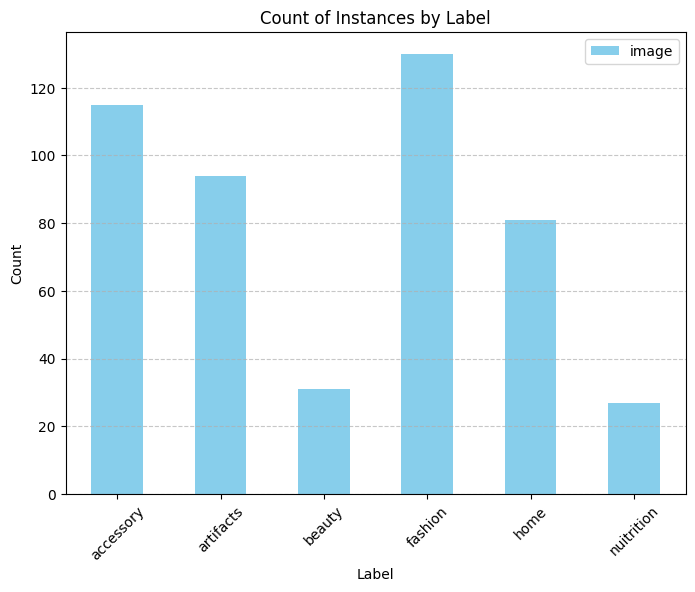

In [6]:
# Grouping by label and counting instances
selected_columns = ['image', 'label']
label_counts = slash_df[selected_columns].groupby('label').count()

# Plotting the bar chart
label_counts.plot(kind='bar', figsize=(8, 6), color='skyblue')
plt.title('Count of Instances by Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Data Preparation

Batch size of `8` so the model learns the pattern fast (as batch size increases model learning rate increases).
And we will shuffle the whole dataset

In [7]:
SHAPE = X[0].shape[0]
BATCH_SIZE = 8
SHUFFLE_SIZE = 1_000

In [8]:
# To Interpret the prediction result
def get_category(y_hat, cols):
    max_value = y_hat.max()
    for index, category in enumerate(y_hat):
        if category == max_value:
            return cols[index]
    
    return 'unknown'

def augment_image(image, label):
    # Randomly flip the image horizontally
    img = tf.image.random_flip_left_right(image)
    
    # Randomly flip the image vertically
    img = tf.image.random_flip_up_down(img)
    
    # Randomly adjust the brightness of the image
    img = tf.image.random_brightness(img, max_delta=0.2)
    
    # Randomly adjust the saturation of the image
    img = tf.image.random_saturation(img, lower=0.5, upper=1.5)
    
    return img, label

def tensor_slices_dataset(x, y, shuffle_size = SHUFFLE_SIZE, batch_size = BATCH_SIZE, training=False):
    data = tf.data.Dataset.from_tensor_slices((x, y))
    
    if training:
        augmented_data = data.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        data = data.concatenate(augmented_data)

        
    data = data.shuffle(shuffle_size)
    data = data.batch(batch_size)
    data = data.prefetch(tf.data.experimental.AUTOTUNE)
    
    return data

In [9]:
# Divide each pixel value by 255 to normalize it to the range [0, 1]
if X[0].dtype == 'uint8':
    for index in tqdm(range(len(X))):
        normalized_image = X[index] / 255.0
        rounded_image = np.round(normalized_image, decimals=5)

        X[index] = rounded_image

100%|██████████| 478/478 [00:03<00:00, 126.15it/s]


In [10]:
# One-Hot-Encoded labels
y = pd.get_dummies(slash_df['label'])
_columns = y.columns 

print(_columns)
y.head()

Index(['accessory', 'artifacts', 'beauty', 'fashion', 'home', 'nuitrition'], dtype='object')


,accessory,artifacts,beauty,fashion,home,nuitrition
0,False,False,True,False,False,False
1,False,False,True,False,False,False
2,False,False,True,False,False,False
3,False,False,True,False,False,False
4,False,False,True,False,False,False


In [11]:
# Split the data into training, and validating sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=slash_df['label'])
print(y_train.shape, y_val.shape)

(382, 6) (96, 6)


accessory     False
artifacts      True
beauty        False
fashion       False
home          False
nuitrition    False
Name: 312, dtype: bool


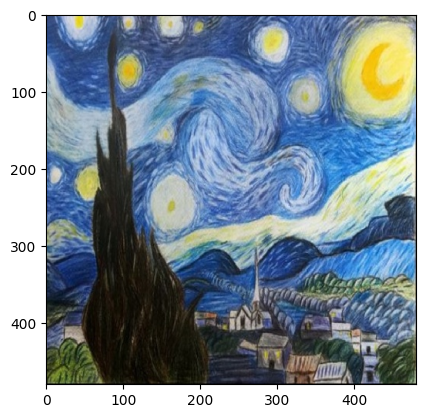

In [12]:
# Viewing a random sample
idx = random.randint(0, y_train.shape[0] - 1)

print(y_train.iloc[idx])
plt.imshow(X_train[idx])

In [13]:
# Generating tensor-dataset to train model with
train_tensor = tensor_slices_dataset(X_train, y_train, training=True)
val_tensor = tensor_slices_dataset(X_val, y_val)

train_tensor.take(1) # Sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, 480, 480, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 6), dtype=tf.bool, name=None))>

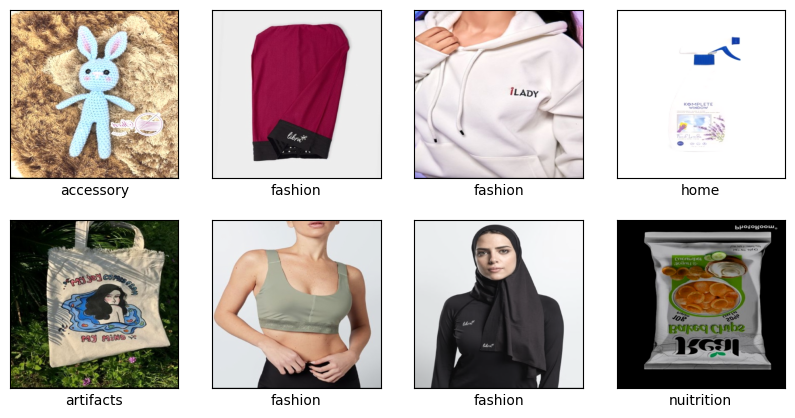

In [14]:
for x, y in train_tensor.take(1):
    plt.figure(figsize=(10,5))
    
    for i in range(8):                
        plt.subplot(2, 4, i+1)
        plt.imshow(x[i])
        
        plt.xlabel(get_category(np.array(y[i]), _columns))
        plt.xticks([])
        plt.yticks([])      

# Model Building

We will use mainly the `ModelCheckpoint` callback function to save the best model having least `val_loss`.<br>
We will use `DenseNet121` as transfer learning because of data size, so we need a pretrained model weights.

In [15]:
best_model_filepath = '/kaggle/working/model/model_checkpoint.keras'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=best_model_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

In [16]:
# Using TransferLearning 'DenseNet121'
base_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(SHAPE, SHAPE, 3))
base_model.trainable = False

# base_model.summary()
# tf.keras.utils.plot_model(base_model, to_file='./logs/InceptionResNetV2.jpg')

In [17]:
# building model up using functional apis
input_layer = tf.keras.layers.Input(shape=(SHAPE, SHAPE, 3))

tl_model = base_model(input_layer, training=False)

x = tf.keras.layers.Flatten()(tl_model)

x = tf.keras.layers.Dense(units=256, activation='leaky_relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(units=128, activation='leaky_relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)

output_layer = tf.keras.layers.Dense(units=_columns.shape[0], activation='softmax')(x)

model = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 480, 480, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 15, 15, 1024)   │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 230400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    58,982,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,054,854 (251.98 MB)

 Trainable params: 59,016,838 (225.13 MB)

 Non-trainable params: 7,038,016 (26.85 MB)

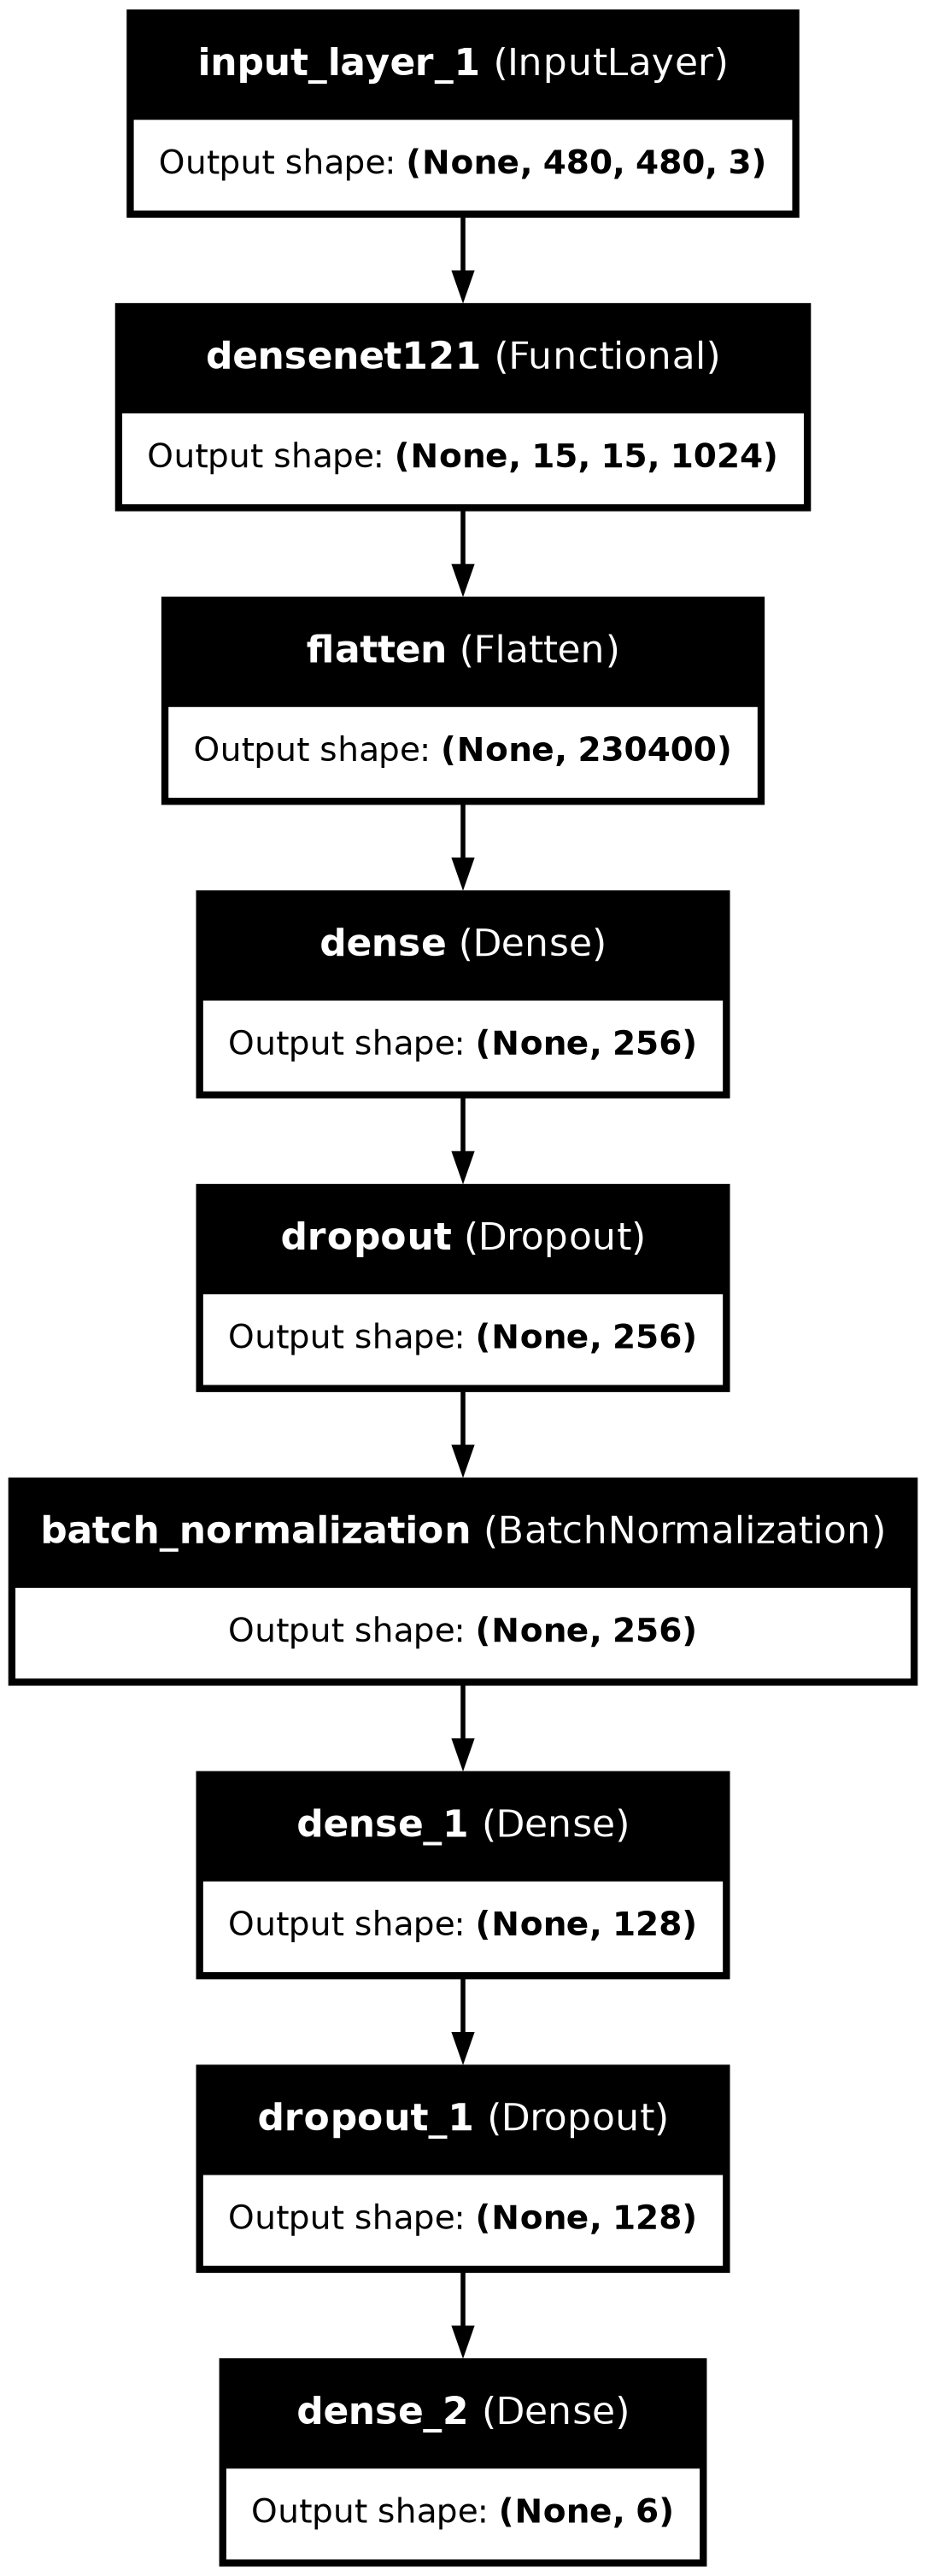

In [18]:
# Plotting model
tf.keras.utils.plot_model(model, to_file='/kaggle/working/model_plot.png', show_shapes=True, show_layer_names=True)

# Model Training

As an optimizer we will pick `adam` for its well known efficiency with a learning rate of `0.0001`.<br>
Training the model for `20 epochs` 10 epochs, and then another 10 epochs.

In [19]:
# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])

In [20]:
# Training model
model.fit(train_tensor,
          batch_size=BATCH_SIZE,
          epochs=30,
          validation_data=val_tensor,
          callbacks = [model_checkpoint_callback])

Epoch 1/30
 1/96 ━━━━━━━━━━━━━━━━━━━━ 1:14:15 47s/step - acc: 0.1250 - loss: 2.2221

I0000 00:00:1711125252.873269     423 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711125252.948745     423 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - acc: 0.4148 - loss: 1.7585

W0000 00:00:1711125295.989756     424 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 0.50906, saving model to /kaggle/working/model/model_checkpoint.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 95s 506ms/step - acc: 0.4156 - loss: 1.7555 - val_acc: 0.8333 - val_loss: 0.5091
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - acc: 0.7312 - loss: 0.7360
Epoch 2: val_loss improved from 0.50906 to 0.33704, saving model to /kaggle/working/model/model_checkpoint.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step - acc: 0.7313 - loss: 0.7358 - val_acc: 0.9167 - val_loss: 0.3370
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - acc: 0.8298 - loss: 0.4780
Epoch 3: val_loss improved from 0.33704 to 0.29162, saving model to /kaggle/working/model/model_checkpoint.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 165ms/step - acc: 0.8300 - loss: 0.4776 - val_acc: 0.9479 - val_loss: 0.2916
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - acc: 0.9066 - loss: 0.3263
Epoch 4: val_loss did not improve from 0.29162
96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - acc: 0

# Model Testing

In [21]:
# Load the saved model
model = load_model('/kaggle/working/model/model_checkpoint.keras')

# Testing our model
test_loss, test_accuracy = model.evaluate(val_tensor)

# Printing the test results
print('Test loss: {0:.4f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 742 variables whereas the saved optimizer has 18 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


 2/12 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - acc: 1.0000 - loss: 0.0562

W0000 00:00:1711125827.911177     423 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 97ms/step - acc: 0.9634 - loss: 0.1343
Test loss: 0.1649. Test accuracy: 94.79%


In [22]:
# Assuming you have already trained your model and have predictions on the validation data
predictions = model.predict(val_tensor)
y_true = np.argmax(y_val, axis=1)  # Assuming y_val is one-hot encoded

# Convert predictions to class labels
y_pred = np.argmax(predictions, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Calculate precision and recall for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)

# Calculate true positives, true negatives, false positives, and false negatives for each class
TP = np.diag(conf_matrix)
FP = np.sum(conf_matrix, axis=0) - TP
FN = np.sum(conf_matrix, axis=1) - TP
TN = np.sum(conf_matrix) - (TP + FP + FN)

# Print metrics
print("Precision:", precision)
print("Recall:", recall)

# Print classification report
print(classification_report(y_true, y_pred))

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step

W0000 00:00:1711125843.939740     421 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step
Precision: [0.26923077 0.15789474 0.         0.32       0.28571429 0.        ]
Recall: [0.30434783 0.15789474 0.         0.30769231 0.25       0.        ]
              precision    recall  f1-score   support

           0       0.27      0.30      0.29        23
           1       0.16      0.16      0.16        19
           2       0.00      0.00      0.00         6
           3       0.32      0.31      0.31        26
           4       0.29      0.25      0.27        16
           5       0.00      0.00      0.00         6

    accuracy                           0.23        96
   macro avg       0.17      0.17      0.17        96
weighted avg       0.23      0.23      0.23        96



# Prediction Phase
Model in action

In [23]:
#  To read image
def read_image(img_path, _shape = SHAPE):
    img = cv2.imread(img_path)[:,:,::-1]
    img = cv2.resize(img, (_shape, _shape))
    img = np.round(img / 255, decimals=5)
    return img

# To Interpret the prediction result
def get_category(y_hat, cols):
    max_value = y_hat.max()
    for index, category in enumerate(y_hat):
        if category == max_value:
            return cols[index]
    
    return 'unknown'
    
def make_prediction(model, image, cols = ['accessory', 'artifacts', 'beauty', 'fashion', 'home', 'nuitrition']):
    # Make a prediction
    predictions = model.predict(tf.expand_dims(image, 0))

    # Display The prediction
    print(f'the image is {get_category(predictions[0], cols)}')
    
    plt.imshow(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
the image is artifacts


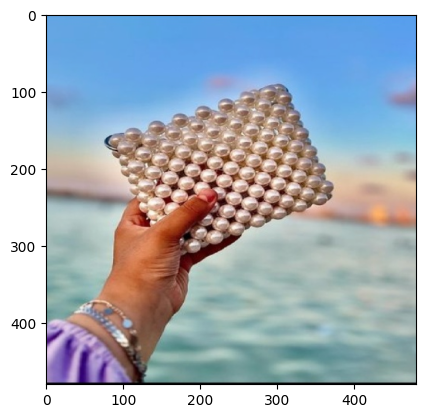

In [39]:
# Predicting on the validation dataset
make_prediction(model, X_val[40])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
the image is beauty


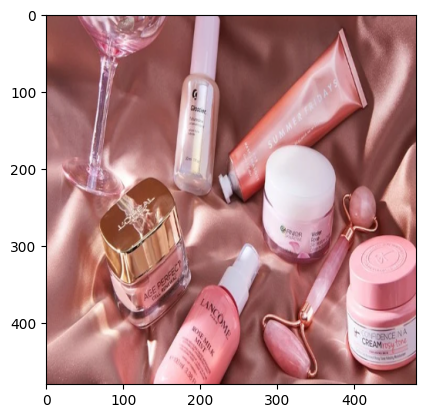

In [38]:
# Predicting on the test dataset
test_img = read_image('/kaggle/input/slash-dataset/test-images/beauty/test_image (2).jpg')
make_prediction(model, test_img)